# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Imports

In [1]:
from sys import platform
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

### 2. Start the Environment

In [2]:
if platform == "darwin":
    file_name = 'Reacher.app'
else:
    file_name = 'Reacher_Linux/Reacher.x86_64'

# load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name=file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1719999961555004


### 4. Instantiate Agent

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

### 5. Train

Episode 10	Score: 0.58	Average Score: 0.39
Episode 20	Score: 0.79	Average Score: 0.61
Episode 30	Score: 0.94	Average Score: 0.66
Episode 40	Score: 1.27	Average Score: 0.79
Episode 50	Score: 2.76	Average Score: 0.91
Episode 60	Score: 1.80	Average Score: 1.06
Episode 70	Score: 2.37	Average Score: 1.21
Episode 80	Score: 2.52	Average Score: 1.32
Episode 90	Score: 3.31	Average Score: 1.50
Episode 100	Score: 2.77	Average Score: 1.67
Episode 110	Score: 2.95	Average Score: 1.91
Episode 120	Score: 3.05	Average Score: 2.12
Episode 130	Score: 2.26	Average Score: 2.32
Episode 140	Score: 2.68	Average Score: 2.48
Episode 150	Score: 2.87	Average Score: 2.62
Episode 160	Score: 3.23	Average Score: 2.72
Episode 170	Score: 2.00	Average Score: 2.73
Episode 180	Score: 1.46	Average Score: 2.70
Episode 190	Score: 1.78	Average Score: 2.58
Episode 200	Score: 2.43	Average Score: 2.49
Episode 210	Score: 2.85	Average Score: 2.46
Episode 220	Score: 2.50	Average Score: 2.47
Episode 230	Score: 2.54	Average Score: 2.

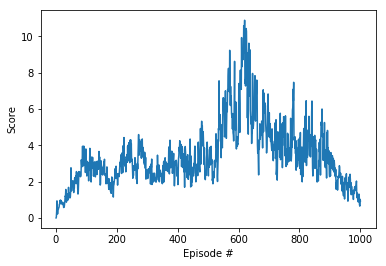

In [7]:
def ddpg(n_episodes=1000, max_t=int(1e6), print_every=10):
    mean_scores_deque = deque(maxlen=100)
    mean_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for i, (state, action, reward, next_state, done) in enumerate(zip(states, actions, rewards, next_states, dones)):
                agent.step(state, action, reward, next_state, done, learn=(t % 20 == 0 and i % 2 == 0))

            scores += env_info.rewards
            states = next_states
            if np.any(dones):
                break

        mean_score = np.mean(scores)
        mean_scores_deque.append(mean_score)
        mean_scores.append(mean_score)
        mean_score_last_n_episodes = np.mean(mean_scores_deque)
        
        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, mean_score, mean_score_last_n_episodes), end='')
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, mean_score, mean_score_last_n_episodes))
            
        if mean_score_last_n_episodes >= 30 and i_episode >= 100:
            print('Problem solved after {} epsisodes!! Average score: {:.2f}'.format(i_episode, mean_score_last_n_episodes))
            break
            
    return mean_scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Smart agent

In [8]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

Total score: 0.6819999847561121


### 6. Close environment

In [9]:
env.close()